# Teste Técnico de Engenharia de Dados

## Baixando, instalando e configurando o Apache Spark

In [0]:
# Instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Baixando Apche Spark que será salvo em no diretorio "/content/"
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
# Baixando bibliotecas
!pip install -q findspark
!pip install pyspark[sql]
!pip install seaborn
!pip install geopandas

In [0]:
# Configurar as variáveis de ambiente do Linux que o Google Colab rodar em cima
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
# Tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

# Iniciar uma sessão local
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession.builder.master('local[*]').getOrCreate()
sqlContext = SQLContext(spark)

spark.conf.set("spark.driver.maxResultSize", "0")
spark.conf.set("spark.executor.memory", "11g")
spark.conf.set("spark.driver.memory	", "11g")

# Necessário para poder usar o ".toPandas()" de forma otimizada com grandes quantidades de dados: 
# - https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toPandas
# - https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.fallback.enabled", "true")

## Criando conexão com o Google Drive e importando datasets

In [0]:
# Criando conexão com o Google Drive da conta que está utilizando o Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Trips
df_trips = spark.read.json("drive/My Drive/datasets/processos-seletivos/datasprints/trips/*.json")

In [0]:
# Vendor
df_vendor = sqlContext.read \
                      .format("com.databricks.spark.csv") \
                      .option("header", "true") \
                      .load("drive/My Drive/datasets/processos-seletivos/datasprints/vendor-lookup/data-vendor_lookup-csv.csv")

## 1 - Qual a distância média percorrida por viagens com no máximo 2 passageiros.

In [0]:
# Cria uma tabela temporaria para que assim seja possível utilizar a sintaxe de SQL ANSI
df_trips.registerTempTable("tb_trips")

# Faz a consulta SQL pelo Spark
df_trips_media_distancia = spark.sql("SELECT AVG(trip_distance) media_distancia FROM tb_trips WHERE passenger_count = 2")

# Removendo a tabela da memória
spark.catalog.uncacheTable("tb_trips")

df_trips_media_distancia.show(truncate=False)

+-----------------+
|media_distancia  |
+-----------------+
|2.835128496886786|
+-----------------+



## 2 - Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado.

In [0]:
# Importando para conversar números para decimal
from pyspark.sql.types import DecimalType

# Criando uma tabela temporaria para que assim seja possível utilizar a sintaxe de SQL ANSI
df_trips.registerTempTable("tb_trips")
df_vendor.registerTempTable("tb_vendor")

# Colocando as tabelas em cache
spark.catalog.cacheTable("tb_trips")
spark.catalog.cacheTable("tb_vendor")

consulta_sql = """
SELECT SUM(T.total_amount) sum_total_amount, T.vendor_id, V.name 
FROM tb_trips T
JOIN tb_vendor V ON (T.vendor_id = V.vendor_id)
GROUP BY T.vendor_id, V.name
ORDER BY sum_total_amount DESC LIMIT 3"""

# Fazendo a consulta SQL pelo Spark
df_maiores_vendors = spark.sql(consulta_sql)

# Convertendo a coluna "sum_total_amount" para decimal, pois do contrário os valores serão exibidos em notação cientifica
df_maiores_vendors = df_maiores_vendors.withColumn('sum_total_amount', df_maiores_vendors.sum_total_amount.cast(DecimalType(18, 2)))

# Removendo as tabelas da memória
spark.catalog.uncacheTable("tb_trips")
spark.catalog.uncacheTable("tb_vendor")

df_maiores_vendors.show(truncate=False)

+----------------+---------+---------------------------------+
|sum_total_amount|vendor_id|name                             |
+----------------+---------+---------------------------------+
|19549084.28     |CMT      |Creative Mobile Technologies, LLC|
|19043434.00     |VTS      |VeriFone Inc                     |
|2714901.72      |DDS      |Dependable Driver Service, Inc   |
+----------------+---------+---------------------------------+



## 3 - Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


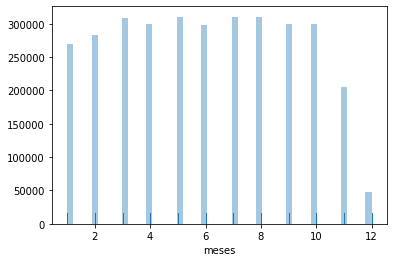

In [0]:
import pandas as pd
import seaborn as sns

# Criando uma tabela temporaria para que assim seja possível utilizar a sintaxe de SQL ANSI
df_trips.registerTempTable("tb_trips")

# Colocando a tabela em cache
spark.catalog.cacheTable("tb_trips")

consulta_sql = """
SELECT SUBSTRING(dropoff_datetime, 6, 2) meses, tb_trips.*
FROM tb_trips
WHERE UPPER(payment_type) = 'CASH'"""

# Fazendo a consulta SQL pelo Spark
df_hist_distri_mes = spark.sql(consulta_sql)

# Removendo a tabela da memória
spark.catalog.uncacheTable("tb_trips")

# Transformando um Datafram Spark em um Datafram Pandas
df_pandas_mes = df_hist_distri_mes.toPandas()

# Trocando todos os valores "Cash" por "CASH" na coluna "payment_type"
df_pandas_mes.loc[(df_pandas_mes.payment_type == 'Cash'),'payment_type']='CASH'

# Convertendo colunas para "datetime"
df_pandas_mes["dropoff_datetime"] = pd.to_datetime(df_pandas_mes["dropoff_datetime"])
df_pandas_mes["pickup_datetime"] = pd.to_datetime(df_pandas_mes["pickup_datetime"])

# Plotando gráfico
sns.distplot(df_pandas_mes["meses"], kde=False, rug=True)

## 4 - Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


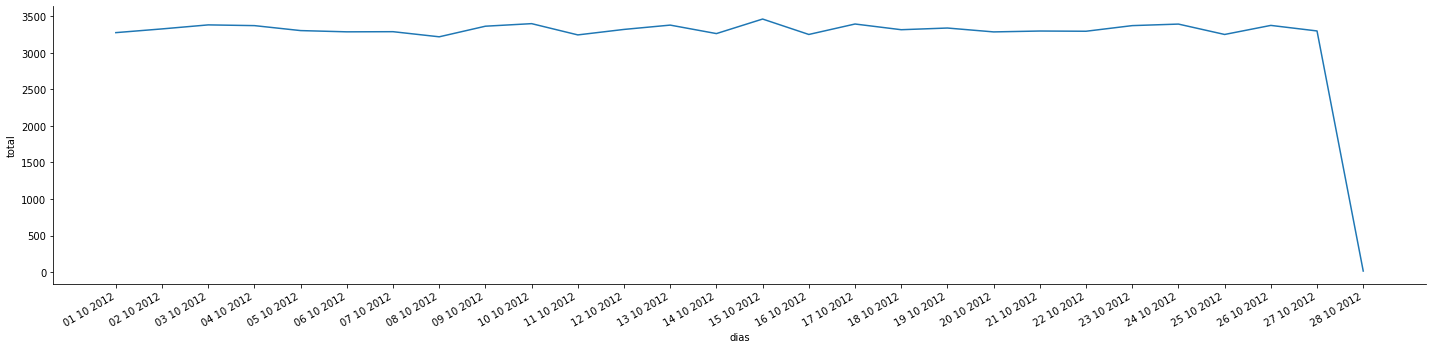

In [0]:
import pandas as pd
from datetime import datetime as dt

# Criando uma tabela temporaria para que assim seja possível utilizar a sintaxe de SQL ANSI
df_trips.registerTempTable("tb_trips")

consulta_sql = """
SELECT SUBSTRING(dropoff_datetime, 1, 10) dias, tb_trips.*
FROM tb_trips"""

# Fazendo a consulta SQL pelo Spark
df_hist_distri_dia = spark.sql(consulta_sql)

# Transformando um Datafram Spark em um Datafram Pandas
df_pandas_dia = df_hist_distri_dia.toPandas()

# Convertendo colunas para "datetime"
df_pandas_dia["dias"] = pd.to_datetime(df_pandas_dia["dias"])

# Pegando dados dos ultimos 3 meses
df_pandas_dias_tres_meses = df_pandas_dia[df_pandas_dia["dias"] > '2012-09-30']

# Agrupando pelos dias
df_group = df_pandas_dias_tres_meses.groupby('dias')

# Contando gorjetas por dia
df_group = df_group["tip_amount"].count()

# Voltando os dados para o formato Dataframe
df_serie_temp = df_group.to_frame().reset_index()

# Renomeando colunas
df_serie_temp.columns = ["dias", "total"]

# Mudando formato das datas para ficar melhor visualmente no gráficos
df_serie_temp["dias"] = df_serie_temp['dias'].apply(lambda x: x.strftime('%d %m %Y'))

# Plotando gráfico
g = sns.relplot(x="dias", y="total", kind="line", data=df_serie_temp, aspect = 4)
g.fig.autofmt_xdate()

## 5 - Qual o tempo médio das corridas nos dias de sábado e domingo.

In [0]:
import pandas as pd
from datetime import datetime as dt

# Criando uma tabela temporaria para que assim seja possível utilizar a sintaxe de SQL ANSI
df_trips.registerTempTable("tb_trips")

consulta_sql = """
SELECT tb_trips.*, SUBSTRING(dropoff_datetime, 1, 10) dias
FROM tb_trips"""

# Fazendo a consulta SQL pelo Spark
df_fim_semana = spark.sql(consulta_sql)

# Transformando um Datafram Spark em um Datafram Pandas
df_pandas_fim_semana = df_fim_semana.toPandas()

# Convertendo colunas para "datetime"
df_pandas_fim_semana["dias"] = pd.to_datetime(df_pandas_fim_semana["dias"])

# Criando lista com nomes dos dias da semana
nomes_semana = ["DOM", "SEG", "TER", "QUA", "QUI", "SEX", "SAB"]

# Pega a data, por exemplo "2009-04-21", e nessa data é aplicado o "strftime("%w")".
# Essa função retorna numeros de 0 a 6, sendo que 0 representa o domingo, 1 representa a segunda e assim por diante.
# Então aplicando esse numero retornado pela função na lista definada previamente, é possível retornar da lista o nome do dia da semana de forma correta.
# Aplicando isso com o "apply" em uma função "lambda" eu consigo fazer isso para todos os registros da coluna "dias" e jogar o resultado na coluna "dia".
# df_pandas_fim_semana["dia"] = df_pandas_fim_semana['dias'].apply(lambda x: x.strftime('%w'))
df_pandas_fim_semana["dia"] = df_pandas_fim_semana['dias'].apply(lambda x: nomes_semana[int(x.strftime("%w"))])

# Pegando dados de sabádo e domingo
df_pandas_fim_semana = df_pandas_fim_semana[df_pandas_fim_semana["dia"].isin(['SAB', 'DOM'])]

# Convertendo colunas para "datetime"
df_pandas_fim_semana["dropoff_datetime"] = pd.to_datetime(df_pandas_fim_semana["dropoff_datetime"])
df_pandas_fim_semana["pickup_datetime"] = pd.to_datetime(df_pandas_fim_semana["pickup_datetime"])

# Pegando tempo das corridas
df_pandas_fim_semana['temp_corrida'] = df_pandas_fim_semana['dropoff_datetime'] - df_pandas_fim_semana['pickup_datetime']

# Pegando média de tempo das corridas
media_temp_corridas = df_pandas_fim_semana['temp_corrida'].mean()

print('\n')
print("Tempo médio das corridas nos dias de sábado e domingo: " + str(media_temp_corridas))

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "




Tempo médio das corridas nos dias de sábado e domingo: 0 days 00:08:44.787484
